Author: Giovanni Bignardi -- 100355842@alumnos.uc3m.es


# Machine Learning

## Homework #6: Hidden Markov Models for speech processing

### A. The three Basic Problems for HMMs

For convenience, we use the compact notation 

$$\lambda=(A, B,  \pi)$$

to indicate the complete parameter set of the model, where $A$ is the state transition probability distribution, $B$ the emission probability distribution (which can be any distribution with parameters $\Theta$) and $\pi$ the initial state distribution.

### Problem 1: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do efficiently compute $P(O|\lambda)$?
Problem 1 is the evaluation problem, namely given a model and a sequence of observations, how do we compute the probability that the observed sequence was produced by the model. To solve this problem we use the **forward-backward algorithm**.

### Problem 2: 
Given the observation sequence $O=O_1, O_2, ..., O_T$, and a model $\lambda=(A, B,  \pi)$, how do we choose a corresponding state sequence $Q= q_1, q_2, ..., q_T$?
Problem 2 is the one in which we attempt to uncover the hidden part of the model, that is, the "correct" state sequence. A formal technique for finding thes best state sequence is based on dynamic programming methods, and is called **the Viterbi algorithm**.


### Problem 3: 
How do we adjust the model parameters $\lambda=(A, B,  \pi)$ to maximize the probability of the observation sequence given the model $P(O|\lambda)$?
There is no known way to analytically solve this problem. We can, however, choose $\lambda=(A, B,  \pi)$ such that $P(O|\lambda)$? is locally maximized using an iterative procedure such as the **the Baum-Welch algoritm** (or equivalently th EM algorithm).




**Reference**

Lawrence R. Rabiner "A tutorial on hidden Markov models and selected applications in speech recognition" Proceedings of the IEEE 77.2, 1989

### B. Problem description

The aim of this session is to design a HMM-based speech recogniser.

The idea is to design a **word speech recogizer**. For each word of the 7 available words we want to fit a separate N-state HMM. We represent the speech signal of a given word as a **time sequence of coded spectral feature vectors**. For each word, we have a training sequence consisting of 15 repetitions of sequences (by one or more talkers).

* The first task is to build individual word models. **This task is done by using the solution to Problem 3** to optimally estimate model parameters for each word model.

* **To understand the physical meaning of the model states, we use the solution to Problem 2** to divide each of the word training sequences into states, and then study the properties of the spectral vectors that lead to the observation ocurring in each state.

* Finally, once the set of 7 HMMs has been fitted and optimized , **recognition of unknown word is performed using the solution of Problem 1**.

The file ``words_db.pickle`` contains 15 instances of 7 different words. ``words_db['signals']`` contains the audio signals at a sampling frequency of 8 KHz, ``words_db['features']`` contains a 6 dimensions frequency feature sequences extracted from the audio signals, and ``words_db['word_labels']`` contains the transcription of the words. 

Depending on the computer hardware specifications, the signals can be reproduced using the package ``audiolab`` from ``scikits``.

## 1. Word sequences modeling

* Divide the instances of the word ``apple`` into train (5) and test (10)
* Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences
* Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results.

###  Load the file

In [1]:
%matplotlib inline

import numpy as np
import scipy
from hmmlearn.hmm import GaussianHMM
from sklearn import preprocessing
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.simplefilter("ignore")

with open('words_db.pickle', 'rb') as handle:
    words_db = pickle.load(handle, encoding='latin1') 
    

In [2]:
# signals
signals=words_db['signals']
# features
features=words_db['features']
# words labels
labels=words_db['labels']
#print the different words
words = list(set(labels))
print(words)

['pineapple', 'lime', 'apple', 'orange', 'banana', 'peach', 'kiwi']


In [3]:
def getTrainTestSets(features,idx):
    #idx is the index vector identifying a given word 
    numsq_train=5 #the number of sequences used in the training set
    numsq_test=10 #the number of sequences used in the test set
    seqlenght_train = np.empty(numsq_train) #sequence length 
    x_train = np.empty([0,6])
    for i in range(numsq_train):
        x_train = np.append(x_train,np.transpose(features[idx[i]]),axis=0)
        seqlenght_train[i] = int(features[idx[i]].shape[1])
    #-------------------------
    seqlenght_test = np.empty(numsq_test)
    x_test = np.empty([0,6])
    for i in range(numsq_train,15):
        x_test = np.append(x_test,np.transpose(features[idx[i]]),axis=0)
        seqlenght_test[i-numsq_train] = int(features[idx[i]].shape[1])

    return x_train,seqlenght_train,x_test,seqlenght_test,



### Select the instances of the word apple and split into train and test

In [4]:
apple_ix = [i for i, j in enumerate(labels) if j == 'apple']

apple_train, apple_seqtrain, apple_test, apple_seqtest = getTrainTestSets(features, apple_ix)

In [5]:
apple_train.shape

(258, 6)

### Train a HMM with Gaussian emission probability and 3 hidden states using the train sequences and evaluate the loglikelihood on the test sequences

In [6]:
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(apple_train, apple_seqtrain.astype(int))

ll = model.score(apple_test, apple_seqtest.astype(int))

print('Log-likelihood score with 3 hidden states =',ll)

Log-likelihood score with 3 hidden states = -26372.0682183


### Plot the loglikelihood on the test sequences using a number of hidden states from 1 to 10 and comment the obtained results.

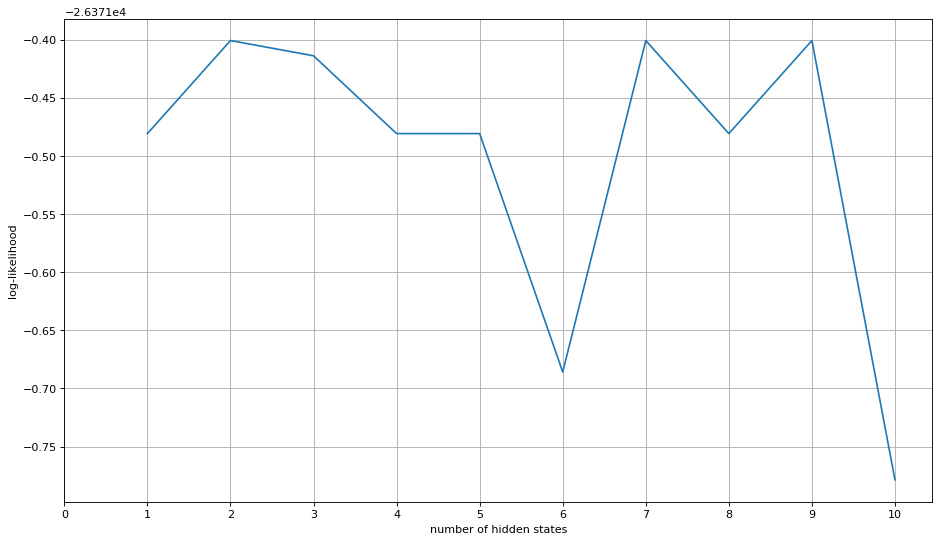

In [7]:
%matplotlib inline

ll = []
for i in range(1,11):
    model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000).fit(apple_train, apple_seqtrain.astype(int))

    ll.append(model.score(apple_test, apple_seqtest.astype(int)))


figure = plt.figure(figsize=(14,8), edgecolor='k', facecolor='w', dpi=80)
plt.plot(range(1,11),ll)
plt.ylabel('log-likelihood')
plt.xlabel('number of hidden states')
plt.xticks(range(0,11))
plt.grid()

When commenting this plot, the first consideration to do is that we achieve the highest log-likelihood (-26371.4139) with 6 hidden states. Indeed, the main school of thought, for what concerns the choice of parameters in word models, says exactly to let the number of states to correspond to the number of sounds within the word.

Another approach would be to let the number of states correspond to the number of observations in a spoken version of the word. This would eventually correspond to the 10-states observation.

Eventually we could say that 3 hidden states performs well because phomens (human sounds) sound different at the beginning, in the middle and at the end.

***

### 2. Word classifier

We will now train a different HMM for each word, and the output of the classifier will be the word with higher loglikelihood.
* Divide the instances of each word into train (5) and test (10)
* Train the HMM's and estimate the classification error on the test instances. Print out the confusion matrix.
* Use LOO onto the train instances to select the number of hidden states. Try values from 1 to 5.

In [19]:
def HMMtrainer(words):
    global models
    global lls
      
    models = {}
    words_test = {}
    words_seqtest = {}
    for word in words:
        word_ix = [i for i, j in enumerate(labels) if j == word]
        word_train, word_seqtrain, word_test, word_seqtest = getTrainTestSets(features, word_ix)
        words_test[word] = word_test
        words_seqtest[word] = word_seqtest
        models[word] = GaussianHMM(n_components=20,
                                   covariance_type="diag",
                                   n_iter=1000).fit(word_train, word_seqtrain.astype(int))
        
    return models, words_test, words_seqtest

In [ ]:
import timeit

start = timeit.timeit()

models, words_test, words_seqtest = HMMtrainer(words)

end = timeit.timeit()
print(end - start)

In [6]:
tested_words = words
predictions = {}
for tested_word in tested_words:
    print('label: ',tested_word)
    lls = {}
    for word in words:
        lls[word] = models[word].score(words_test[tested_word], words_seqtest[tested_word].astype(int))
        print('evaluate',word,'HMM :', lls[word])
    predictions[tested_word]= max(lls, key=lls.get)


label:  pineapple
evaluate pineapple HMM : -35745.9649016
evaluate lime HMM : -35892.4195212
evaluate apple HMM : -36528.2838702
evaluate peach HMM : -41181.2800046
evaluate kiwi HMM : -41636.6777344
evaluate orange HMM : -37737.8289439
evaluate banana HMM : -36359.1822292
label:  lime
evaluate pineapple HMM : -26689.0450316
evaluate lime HMM : -26477.5007431
evaluate apple HMM : -27182.3797556
evaluate peach HMM : -30813.6162592
evaluate kiwi HMM : -31388.142876
evaluate orange HMM : -28164.2989566
evaluate banana HMM : -27134.7525742
label:  apple
evaluate pineapple HMM : -26851.2062292
evaluate lime HMM : -27810.2980359
evaluate apple HMM : -26372.0360734
evaluate peach HMM : -31085.9533459
evaluate kiwi HMM : -34659.6323171
evaluate orange HMM : -31055.2597575
evaluate banana HMM : -27977.2272281
label:  peach
evaluate pineapple HMM : -67947.3610663
evaluate lime HMM : -88945.5048465
evaluate apple HMM : -61643.9476163
evaluate peach HMM : -42724.4181951
evaluate kiwi HMM : -44044.

In [7]:
labels_test = list(predictions.keys())
predicted_labels = list(predictions.values())

In [9]:
classification_report(labels_test, predicted_labels)

'             precision    recall  f1-score   support\n\n      apple       1.00      1.00      1.00         1\n     banana       1.00      1.00      1.00         1\n       kiwi       1.00      1.00      1.00         1\n       lime       1.00      1.00      1.00         1\n     orange       1.00      1.00      1.00         1\n      peach       1.00      1.00      1.00         1\n  pineapple       1.00      1.00      1.00         1\n\navg / total       1.00      1.00      1.00         7\n'

#### Confusion Matrix
Given that the predictor does very well, I will obtain a diagonal matrix

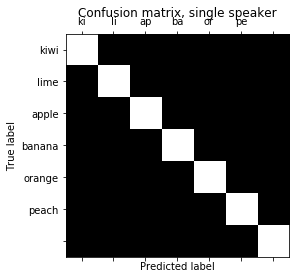

In [8]:
cm = confusion_matrix(labels_test, predicted_labels)
plt.matshow(cm, cmap='gray')
ax = plt.gca()
_ = ax.set_xticklabels(label[:2] for label in labels_test)
_ = ax.set_yticklabels(label for label in predicted_labels)
plt.title('Confusion matrix, single speaker')
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Leave-One-Out

*Note*: I've widened the number of tested hidden-states from 5 to 10 because I was interested to deepen the research

In [149]:
from sklearn.model_selection import LeaveOneOut as loo
def LOOcv(word):
    range_hiddenStates = range(1,11)
    global LOO_lls
    LOO_lls = [] # to store the avg log-likelihood with n hidden-states obtained with each validation of LOO
    # for each hidden-state
    for hs in range_hiddenStates:
        # subset features belonging to a word
        word_ix = [i for i, j in enumerate(labels) if j == word]
        word_feats = features[word_ix]
        # get indices for LOO, using the sklearn.model_selection method
        splits = loo().split(word_feats)
        # to store 
        lls_hs=[]
        # for each pair of indices (the first will be train on [1,2,3,4,5,6,7,8,9,10,11,12,13,14] and test on [0])
        for looTrain_idx, looTest_idx in splits:
            #print(looTrain_idx, looTest_idx)
            # here I readapt the lecturer's function to get train and test folds
            seqlenght_train = np.empty(14) #sequence length 
            x_train = np.empty([0,6])
            for i in range(0,14):
                x_train = np.append(x_train, np.transpose(word_feats[looTrain_idx[i]]),axis=0)
                seqlenght_train[i] = int(word_feats[looTrain_idx[i]].shape[1])
            #----------------------
            x_test = np.transpose(features[looTest_idx[0]])
            seqlenght_test = [features[looTest_idx[0]].shape[1]]

            # fit a GaussianHMM to the train partition
            model = GaussianHMM(n_components=hs,
                                covariance_type="diag",
                                n_iter=1000).fit(x_train, seqlenght_train.astype(int))
            # store the log-likelihood of the model on the test partition
            lls_hs.append(model.score(x_test, seqlenght_test))
        # the score with n hidden-states is an average of the log-likelihoods obtained with the LOOcv 
        print('log-likelihood with ',hs,' hidden states = ',np.mean(lls_hs))
        # I append this mean to LOO_lls
        LOO_lls.append(np.mean(lls_hs))
        # Finally I will choose the number of hidden states that returns the highest avg(ll)
    print('The best number of hidden-states is: ', LOO_lls.index(max(LOO_lls))+1)
    return LOO_lls

In [151]:
for word in words:
    print('\nLOOcv >> search for best number of hidde-states of the GausssianHMM for',word)
    LOOcv(word)


LOOcv >> search for best number of hidde-states of the GausssianHMM for pineapple
log-likelihood with  1  hidden states =  -2620.7704892
log-likelihood with  2  hidden states =  -2636.428503
log-likelihood with  3  hidden states =  -2610.38294104
log-likelihood with  4  hidden states =  -2602.08402715
log-likelihood with  5  hidden states =  -2597.95044681
log-likelihood with  6  hidden states =  -2602.16960068
log-likelihood with  7  hidden states =  -2611.50571879
log-likelihood with  8  hidden states =  -2612.06465483
log-likelihood with  9  hidden states =  -2613.4597839
log-likelihood with  10  hidden states =  -2605.4014654
The best number of hidden-states is:  5

LOOcv >> search for best number of hidde-states of the GausssianHMM for lime
log-likelihood with  1  hidden states =  -2631.63377054
log-likelihood with  2  hidden states =  -2644.94777614
log-likelihood with  3  hidden states =  -2686.56122023
log-likelihood with  4  hidden states =  -2689.3868763
log-likelihood with 